# Majorization-Minimization in TensorFlow

In this notebook I will show a simple example which demonstrates the power of a really clever optimization
technique, called Majorization-Minimization (MM). With MM, one is able to transform a non-differentiable
optimization problem (which often leads to unstable solutions) into a differentiable and therefore stable
optimization problem.

Note: for a theorectical and practical introduction of MM algorithms, see [Majorization-Minimization Algorithms in Signal Processing, Communications, and Machine Learning](http://ieeexplore.ieee.org/document/7547360/) by Y. Sun, P. Babu, and D. P. Palomar

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
np.random.seed(0)
import tensorflow as tf

/Users/jvmirca/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Toy data generation

To begin with, let's generate some toy data which is the result of
adding an independent, non-identically distributed, Poisson process:

In [3]:
x = tf.placeholder(dtype=tf.float64)
y = tf.placeholder(dtype=tf.float64)
x_data = np.linspace(0, 5, 100)

In [4]:
true_slope = 2
true_intercept = 10
y_data = np.random.poisson(x_data * true_slope + true_intercept)

Let's add some outliers as well:

In [5]:
y_data[np.arange(len(x_data)) % 10 == 0] = 3 * y_data[np.arange(len(x_data)) % 10 == 0]

Text(0.5,0,'Bin number')

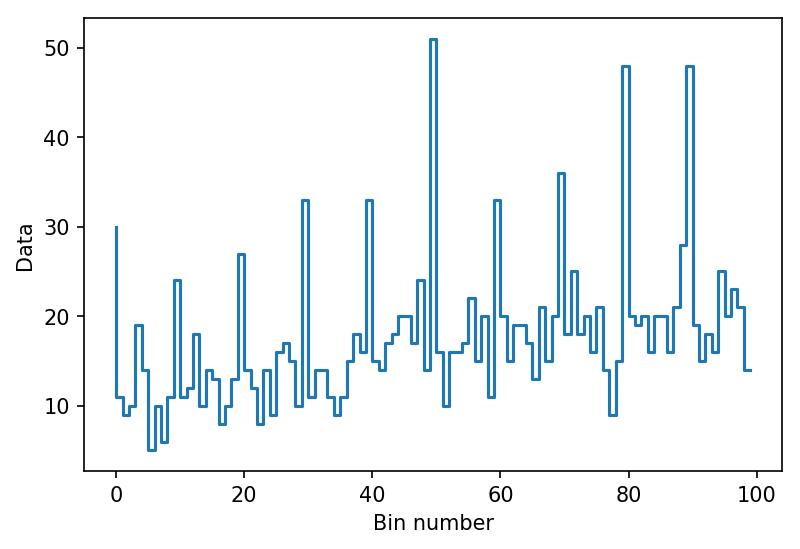

In [6]:
plt.step(np.arange(len(x_data)), y_data)
plt.ylabel("Data")
plt.xlabel("Bin number")

We want to estimate the slope and the intercept of the line that "best" describes
the mean of every Poisson random variable.

In [7]:
def mean(theta):
    m, b = theta[0], theta[1]
    return x * m + b

# Direct Minimization of the L1-Norm

Let's assume that we don't know that the data is comes from a Poisson process,
and also that we are not interested in modeling the outliers, but only the linear
trend. Since our data have outliers, we choose to use the L1-Norm as our cost function:

In [8]:
m = tf.Variable(np.random.normal(), dtype=tf.float64, name='m')
b = tf.Variable(np.random.normal(), dtype=tf.float64, name='b')

In [9]:
# l1-norm
negloglike = tf.reduce_sum(tf.abs(mean((m, b)) - y))
grad = tf.gradients(negloglike, [m, b])

In [10]:
sess = tf.Session()
sess.run(fetches=tf.global_variables_initializer())
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=negloglike, method='BFGS')
optimizer.minimize(session=sess, feed_dict={x: x_data, y: y_data})
grad_opt = sess.run(grad, feed_dict={x: x_data, y: y_data})
l1_opt = [sess.run(m), sess.run(b)]
print(l1_opt, grad_opt)

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 449.252608
  Number of iterations: 5
  Number of functions evaluations: 54
[2.1050409239847778, 10.832882755026946] [2.020202020202019, 0.0]


**Message: Desired error not necessarily achieved due to precision loss.**

Text(0.5,0,'Bin number')

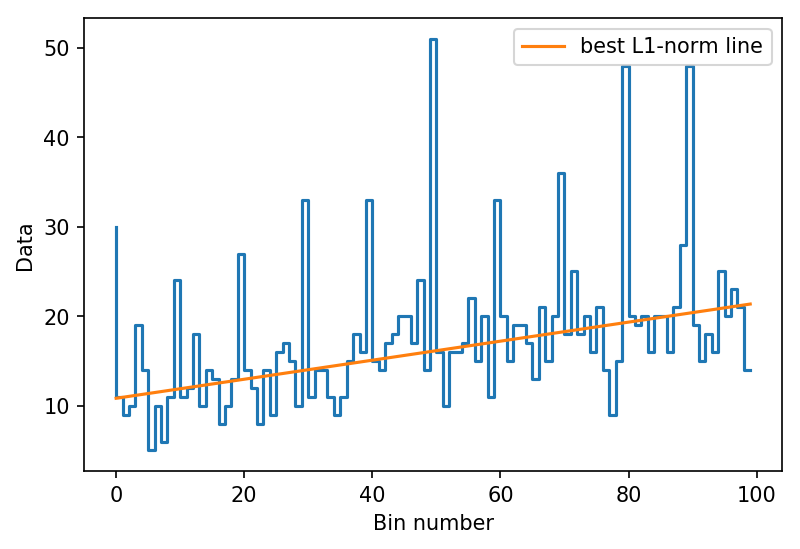

In [11]:
plt.step(np.arange(len(x_data)), y_data)
plt.plot(np.arange(len(x_data)), sess.run(mean((m, b)), feed_dict={x:x_data}),
         label='best L1-norm line')
plt.legend()
plt.ylabel("Data")
plt.xlabel("Bin number")

In [12]:
print("Value of the gradient at final parameter values: {}".format(grad_opt))

Value of the gradient at final parameter values: [2.020202020202019, 0.0]


The gradient value at the solution is a good figure of merit to decide whether or not
the optimization has reached a local minima. However, the gradient value is not meaningful
in this case, since our cost function is non-differentiable in the first place.
In big data systems and high dimensional problems we can't afford looking at plots all the
time to see whether results are good or not.

# Majorization-Minimization

Majorization-minimization allow us to reframe a non-differentiable optimization problem into a differentiable one
by using a "surrogate" function to approximate the objective function.

In [13]:
m = tf.Variable(np.abs(np.random.normal()), dtype=tf.float64, name='m')
b = tf.Variable(np.abs(np.random.normal()), dtype=tf.float64, name='b')
m_n, b_n = np.abs(np.random.normal()), np.abs(np.random.normal()) # initial guess

A possible surrogate function for the L1-norm is given as
\begin{align}
    g(\mathbf{r} | \mathbf{r}_t) = \dfrac{1}{2}\dfrac{||\mathbf{r}||^{2}_2}{||\mathbf{r}_n||_1} + \dfrac{1}{2}||\mathbf{r}_n||_1
\end{align}
which majorizes $||\mathbf{r}||_{1}$ at the point $\mathbf{r}_n$.

In [14]:
r = y - mean((m, b)) # residual vector
abs_r_n = tf.abs(y - mean((m_n, b_n))) # abs value of the residual vector at the previous iteration
negloglike_surrogate = .5 * tf.reduce_sum(r * r / abs_r_n + abs_r_n) # surrogate function
grad = tf.gradients(negloglike_surrogate, [m, b]) # gradient of the surrogate function

In [15]:
sess = tf.Session()
sess.run(fetches=tf.global_variables_initializer())
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=negloglike_surrogate, var_list=[m, b],
                                                   method='BFGS')
i = 0
while i < 20:
    optimizer.minimize(session=sess, feed_dict={x: x_data, y: y_data})
    m_opt = sess.run(m)
    b_opt = sess.run(b)
    m_n_opt = m_n
    b_n_opt = b_n
    grad_opt = sess.run(grad, feed_dict={x: x_data, y: y_data})
    print("Solution: [{}, {}]\nPrevious solution: [{}, {}]\nGradient at solution: [{}]"
          .format(m_opt, b_opt, m_n_opt, b_n_opt, grad_opt))
    m_n, b_n = m_opt, b_opt
    # update surrogate function
    r = y - mean((m, b))
    abs_r_n = tf.abs(y - mean((m_n, b_n)))
    negloglike_surrogate = .5 * tf.reduce_sum(r * r / abs_r_n + abs_r_n)
    grad = tf.gradients(negloglike_surrogate, [m, b])
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=negloglike_surrogate, var_list=[m, b], method='BFGS')
    i+=1

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 734.326830
  Number of iterations: 6
  Number of functions evaluations: 7
Solution: [1.4496763621233597, 10.485754001760487]
Previous solution: [2.16323594928069, 1.336527949436392]
Gradient at solution: [[2.2322854675849158e-10, 4.0236924903069848e-11]]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 498.319702
  Number of iterations: 2
  Number of functions evaluations: 5
Solution: [1.4990495336473753, 10.570419248794593]
Previous solution: [1.4496763621233597, 10.485754001760487]
Gradient at solution: [[8.6153306710912148e-14, 1.7763568394002505e-15]]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 484.897254
  Number of iterations: 2
  Number of functions evaluations: 5
Solution: [1.6671918978343137, 10.6268568600

In [16]:
sess.run(tf.reduce_sum(tf.abs(mean(l1_opt) - y)), feed_dict={x:x_data, y:y_data})

449.25260792724191

In [17]:
sess.run(tf.reduce_sum(tf.abs(mean((m_opt, b_opt)) - y)), feed_dict={x:x_data, y:y_data})

449.20754720343052

1. Gradient is  close to zero on every iteration! => stable optimization!
2. Smaller cost function at reported "best" parameter values!

Remarks: Majorization-minimization algorithms enable us to approximate non-differentiable objective functions
    by differentiable ones which are easier to optimize. This fact gives rise to an iterative procedure to arrive
    at the local minima. Additionally, meaningful gradient information is available at every iteration.